In [6]:
import torch 
params = torch.load('/home/ubuntu/date/hdd4/shadow_model_ckpt/mnist/models_hetero/target_trojB_226.model')
from model_lib.mnist_cnn_model import ModelTest, Model
m = ModelTest()
m.load_state_dict(params)
print(m)

ModelTest(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool_2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)


In [4]:
# Load and preprocess data
import torch
TRAIN_NUM = 10
VAL_NUM = 10
TEST_NUM = 10
shadow_path = './shadow_model_ckpt/%s/models' % 'mnist'
train_dataset = []
for i in range(TRAIN_NUM):
    x = shadow_path + '/shadow_jumbo_%d.model'%i
    train_dataset.append((x,1))
    x = shadow_path + '/shadow_benign_%d.model'%i
    train_dataset.append((x,0))

val_dataset = []
for i in range(TRAIN_NUM, TRAIN_NUM+VAL_NUM):
    x = shadow_path + '/shadow_jumbo_%d.model'%i
    val_dataset.append((x,1))
    x = shadow_path + '/shadow_benign_%d.model'%i
    val_dataset.append((x,0))

test_dataset = []
for i in range(TEST_NUM):
    x = shadow_path + '/target_troj%s_%d.model'%('M', i)
    test_dataset.append((x,1))
    x = shadow_path + '/target_benign_%d.model'%i
    test_dataset.append((x,0))

# print(train_dataset, val_dataset, test_dataset)
import numpy as np 
from torchsummary import summary
from model_lib.mnist_cnn_model import Model
from torch import nn
from cogdl.data import Graph

m = None 
def load_dataset(dataset):
    perm = np.random.permutation(len(dataset))
    graphs = []
    
    for i in perm:
        x, y = dataset[i]
        label = torch.IntTensor([y])
#         print(label)
        basic_model = Model()
        t = torch.load(x)
        t = basic_model.load_state_dict(t)
        
        with torch.no_grad():
            # nodes_feat 512 * 513
            nodes_feat = []
            cnt = 0
            # get conv1 nodes 
            conv1 = {}
            for weight in basic_model.conv1.weight:
                pad = nn.ZeroPad2d(padding=(254,254,253,254))
                feat = pad(weight[0])
                conv1[cnt] = feat
                nodes_feat.append(torch.reshape(feat, (1, 262656))[0])
                cnt += 1
            print(conv1[0].shape)
            # get conv2 nodes
            conv2 = {}
            for weight in basic_model.conv2.weight:
                pad = nn.ZeroPad2d(padding=(254,254,253,254))
                feat = pad(weight[0])
                conv2[cnt] = feat
                nodes_feat.append(torch.reshape(feat, (1, 262656))[0])
                cnt += 1
            print(conv2[16].shape)
            # get conv1 -> conv2 edges
            conv1_2 = []
            for src in conv1.keys():
                for dst in conv2.keys():
                    conv1_2.append([src, dst])


            # get fc node
            fc_index = cnt
            cnt += 1
            fc_node = torch.concat([basic_model.fc.weight, basic_model.fc.bias.reshape(512, 1)], 1)
            nodes_feat.append(torch.reshape(fc_node, (1, 262656))[0])
            print(fc_node.shape)

            # get conv2 -> fc edges
            conv2_fc = []
            for src in conv2.keys():
                conv2_fc.append([src, fc_index])

            # get output node
            out_index = cnt
            cnt += 1 
            out = torch.concat([basic_model.output.weight, basic_model.output.bias.reshape(10, 1)], 1)
            pad = nn.ZeroPad2d(padding=(0,0,251,251))
            out_node = pad(out)
            nodes_feat.append(torch.reshape(out_node, (1, 262656))[0])

            print(out_node.shape)

            # get fc -> output edge
            fc_out_edge = [[fc_index, out_index]]

            # get all nodes
            nodes_feat = torch.stack(nodes_feat)
            print(nodes_feat.shape)
            # get all edges
            all_edges = torch.tensor(conv1_2 + conv2_fc + fc_out_edge).t()
            print(all_edges)
            g = Graph(edge_index=all_edges,x=nodes_feat, y=label)
            print(g.to_scipy_csr())
#             print("nodes:", g.num_nodes)
#             print("edges:", g.num_edges)
            graphs.append(g)
            break
    return graphs
        
res = load_dataset(train_dataset)


torch.Size([512, 513])
torch.Size([512, 513])
torch.Size([512, 513])
torch.Size([512, 513])
torch.Size([50, 262656])
tensor([[ 0,  0,  0,  ..., 46, 47, 48],
        [16, 17, 18,  ..., 48, 48, 49]])
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 20)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 25)	1.0
  (0, 26)	1.0
  (0, 27)	1.0
  (0, 28)	1.0
  (0, 29)	1.0
  (0, 30)	1.0
  (0, 31)	1.0
  (0, 32)	1.0
  (0, 33)	1.0
  (0, 34)	1.0
  (0, 35)	1.0
  (0, 36)	1.0
  (0, 37)	1.0
  (0, 38)	1.0
  (0, 39)	1.0
  (0, 40)	1.0
  :	:
  (24, 48)	1.0
  (25, 48)	1.0
  (26, 48)	1.0
  (27, 48)	1.0
  (28, 48)	1.0
  (29, 48)	1.0
  (30, 48)	1.0
  (31, 48)	1.0
  (32, 48)	1.0
  (33, 48)	1.0
  (34, 48)	1.0
  (35, 48)	1.0
  (36, 48)	1.0
  (37, 48)	1.0
  (38, 48)	1.0
  (39, 48)	1.0
  (40, 48)	1.0
  (41, 48)	1.0
  (42, 48)	1.0
  (43, 48)	1.0
  (44, 48)	1.0
  (45, 48)	1.0
  (46, 48)	1.0
  (47, 48)	1.0
  (48, 49)	1.0


In [ ]:
x =torch.tensor([[0,1],[1,3],[2,1],[4,2],[0,3]])

In [ ]:
x = torch.tensor([[-1,1],[0,1],[1,1],[2,1],[3,1]])

In [ ]:
torch.reshape(x, (1,10))[0]

In [ ]:
import torch
from cogdl.data import Graph
edges = torch.tensor([[0,1],[1,3],[2,1],[4,2],[0,3]]).t()
x = torch.tensor([[-1],[0],[1],[2],[3]])
g = Graph(edge_index=edges,x=x) # equivalent to that above
print(g.edges())

In [ ]:
import hiddenlayer as hl
print(m)
# summary(basic_model, (1, 28, 28))
hl.build_graph(m, torch.zeros([1, 1, 28, 28]).cuda())

In [ ]:
from cogdl.data import Graph
from cogdl.datasets import GraphDataset
import gc
import torch
import numpy as np
from model_lib.mnist_cnn_model import Model
from torch import nn

class MyGraphDataset(GraphDataset):
    def __init__(self, path="./shadow_model_ckpt/mnist/train-data.pt"):
        self.path = path
        super(MyGraphDataset, self).__init__(path, metric="accuracy")

    def process(self):
        # Load and preprocess data
        # Here we randomly generate several graphs for simplicity as an example
        # TRAIN_NUM = 2048
        TRAIN_NUM = 256
        VAL_NUM = 256
        TEST_NUM = 256
        shadow_path = './shadow_model_ckpt/%s/models' % 'mnist'
        graphs = []

        train_dataset = []
        for i in range(TRAIN_NUM):
            x = shadow_path + '/shadow_jumbo_%d.model'%i
            train_dataset.append((x,1))
            x = shadow_path + '/shadow_benign_%d.model'%i
            train_dataset.append((x,0))
        graphs += self.load_dataset(train_dataset)
        del train_dataset
        gc.collect()
        
        val_dataset = []
        for i in range(TRAIN_NUM, TRAIN_NUM+VAL_NUM):
            x = shadow_path + '/shadow_jumbo_%d.model'%i
            val_dataset.append((x,1))
            x = shadow_path + '/shadow_benign_%d.model'%i
            val_dataset.append((x,0))
        graphs += self.load_dataset(val_dataset)
        del val_dataset
        gc.collect()
        
        test_dataset = []
        for i in range(TEST_NUM):
            x = shadow_path + '/target_troj%s_%d.model'%('M', i)
            test_dataset.append((x,1))
            x = shadow_path + '/target_benign_%d.model'%i
            test_dataset.append((x,0))
        graphs += self.load_dataset(test_dataset)
        del test_dataset
        gc.collect()

        return graphs
    
    def load_dataset(self, dataset):
        perm = np.random.permutation(len(dataset))
        graphs = []

        for i in perm:
            x, y = dataset[i]
            label = torch.IntTensor([y])
    #         print(label)
            basic_model = Model().cuda()
            t = torch.load(x)
            t = basic_model.load_state_dict(t)

            with torch.no_grad():
                # nodes_feat 512 * 513
                nodes_feat = []
                cnt = 0
                # get conv1 nodes 
                conv1 = {}
                for weight in basic_model.conv1.weight:
                    pad = nn.ZeroPad2d(padding=(254,254,253,254))
                    feat = pad(weight[0])
                    conv1[cnt] = feat
                    nodes_feat.append(feat)
                    cnt += 1

                # get conv2 nodes
                conv2 = {}
                for weight in basic_model.conv2.weight:
                    pad = nn.ZeroPad2d(padding=(254,254,253,254))
                    feat = pad(weight[0])
                    conv2[cnt] = feat
                    nodes_feat.append(feat)
                    cnt += 1

                # get conv1 -> conv2 edges
                conv1_2 = []
                for src in conv1.keys():
                    for dst in conv2.keys():
                        conv1_2.append([src, dst])


                # get fc node
                fc_index = cnt
                cnt += 1
                fc_node = torch.concat([basic_model.fc.weight, basic_model.fc.bias.reshape(512, 1)], 1)
                nodes_feat.append(fc_node)
                # print(fc_node.shape)

                # get conv2 -> fc edges
                conv2_fc = []
                for src in conv2.keys():
                    conv2_fc.append([src, fc_index])

                # get output node
                out_index = cnt
                cnt += 1 
                out = torch.concat([basic_model.output.weight, basic_model.output.bias.reshape(10, 1)], 1)
                pad = nn.ZeroPad2d(padding=(0,0,251,251))
                out_node = pad(out)
                nodes_feat.append(out_node)

                # print(out_node.shape)

                # get fc -> output edge
                fc_out_edge = [[fc_index, out_index]]

                # get all nodes
                nodes_feat = torch.stack(nodes_feat)
                # print(nodes_feat.shape)
                # get all edges
                all_edges = torch.tensor(conv1_2 + conv2_fc + fc_out_edge).t()

                g = Graph(edge_index=all_edges,x=nodes_feat, y=label)
    #             print("nodes:", g.num_nodes)
    #             print("edges:", g.num_edges)
                graphs.append(g)
        return graphs


In [ ]:
if __name__ == "__main__":
    dataset = MyGraphDataset()
    experiment(model="gin", dataset=dataset)

In [ ]:
import torch
from cogdl.data import Graph
edges = torch.tensor([[0,1],[1,3],[2,1],[4,2],[0,3]]).t()
x = torch.tensor([[-1],[0],[1],[2],[3]])
g = Graph(edge_index=edges,x=x) # equivalent to that above
print(g.edges())

Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)


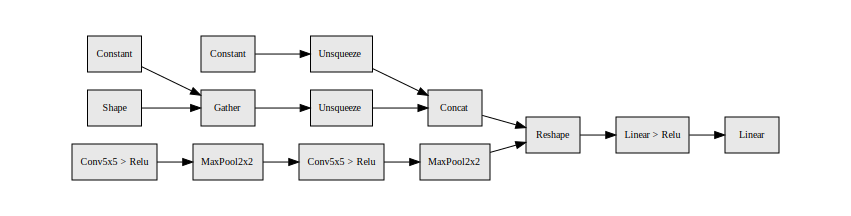

In [14]:
import hiddenlayer as hl
print(m)
# summary(basic_model, (1, 28, 28))
hl.build_graph(m, torch.zeros([1, 1, 28, 28]).cuda())

In [11]:
from cogdl.data import Graph
from cogdl.datasets import GraphDataset
import gc
import torch
import numpy as np
from model_lib.mnist_cnn_model import Model
from torch import nn

class MyGraphDataset(GraphDataset):
    def __init__(self, path="./shadow_model_ckpt/mnist/train-data.pt"):
        self.path = path
        super(MyGraphDataset, self).__init__(path, metric="accuracy")

    def process(self):
        # Load and preprocess data
        # Here we randomly generate several graphs for simplicity as an example
        # TRAIN_NUM = 2048
        TRAIN_NUM = 256
        VAL_NUM = 256
        TEST_NUM = 256
        shadow_path = './shadow_model_ckpt/%s/models' % 'mnist'
        graphs = []

        train_dataset = []
        for i in range(TRAIN_NUM):
            x = shadow_path + '/shadow_jumbo_%d.model'%i
            train_dataset.append((x,1))
            x = shadow_path + '/shadow_benign_%d.model'%i
            train_dataset.append((x,0))
        graphs += self.load_dataset(train_dataset)
        del train_dataset
        gc.collect()
        
        val_dataset = []
        for i in range(TRAIN_NUM, TRAIN_NUM+VAL_NUM):
            x = shadow_path + '/shadow_jumbo_%d.model'%i
            val_dataset.append((x,1))
            x = shadow_path + '/shadow_benign_%d.model'%i
            val_dataset.append((x,0))
        graphs += self.load_dataset(val_dataset)
        del val_dataset
        gc.collect()
        
        test_dataset = []
        for i in range(TEST_NUM):
            x = shadow_path + '/target_troj%s_%d.model'%('M', i)
            test_dataset.append((x,1))
            x = shadow_path + '/target_benign_%d.model'%i
            test_dataset.append((x,0))
        graphs += self.load_dataset(test_dataset)
        del test_dataset
        gc.collect()

        return graphs
    
    def load_dataset(self, dataset):
        perm = np.random.permutation(len(dataset))
        graphs = []

        for i in perm:
            x, y = dataset[i]
            label = torch.IntTensor([y])
    #         print(label)
            basic_model = Model().cuda()
            t = torch.load(x)
            t = basic_model.load_state_dict(t)

            with torch.no_grad():
                # nodes_feat 512 * 513
                nodes_feat = []
                cnt = 0
                # get conv1 nodes 
                conv1 = {}
                for weight in basic_model.conv1.weight:
                    pad = nn.ZeroPad2d(padding=(254,254,253,254))
                    feat = pad(weight[0])
                    conv1[cnt] = feat
                    nodes_feat.append(feat)
                    cnt += 1

                # get conv2 nodes
                conv2 = {}
                for weight in basic_model.conv2.weight:
                    pad = nn.ZeroPad2d(padding=(254,254,253,254))
                    feat = pad(weight[0])
                    conv2[cnt] = feat
                    nodes_feat.append(feat)
                    cnt += 1

                # get conv1 -> conv2 edges
                conv1_2 = []
                for src in conv1.keys():
                    for dst in conv2.keys():
                        conv1_2.append([src, dst])


                # get fc node
                fc_index = cnt
                cnt += 1
                fc_node = torch.concat([basic_model.fc.weight, basic_model.fc.bias.reshape(512, 1)], 1)
                nodes_feat.append(fc_node)
                # print(fc_node.shape)

                # get conv2 -> fc edges
                conv2_fc = []
                for src in conv2.keys():
                    conv2_fc.append([src, fc_index])

                # get output node
                out_index = cnt
                cnt += 1 
                out = torch.concat([basic_model.output.weight, basic_model.output.bias.reshape(10, 1)], 1)
                pad = nn.ZeroPad2d(padding=(0,0,251,251))
                out_node = pad(out)
                nodes_feat.append(out_node)

                # print(out_node.shape)

                # get fc -> output edge
                fc_out_edge = [[fc_index, out_index]]

                # get all nodes
                nodes_feat = torch.stack(nodes_feat)
                # print(nodes_feat.shape)
                # get all edges
                all_edges = torch.tensor(conv1_2 + conv2_fc + fc_out_edge).t()

                g = Graph(edge_index=all_edges,x=nodes_feat, y=label)
    #             print("nodes:", g.num_nodes)
    #             print("edges:", g.num_edges)
                graphs.append(g)
        return graphs


In [10]:
import torch 
data = torch.load('/home/ubuntu/date/hdd4/shadow_model_ckpt/mnist/processed_data/shadow_benign_0.model.pth')
from cogdl.data import Graph


In [13]:
g = Graph(edge_index=data['edges'], y=data['y'])
print(g.num_edges)

545


In [9]:
edges.shape

torch.Size([2, 30])

In [8]:
data['edges'].shape

torch.Size([2, 545])

In [6]:
edges = torch.randint(0, 20, (2, 30))
label = torch.randint(0, 7, (1,))
gg = Graph(edge_index=edges, y=label)
print(gg.num_edges)

30


In [12]:
if __name__ == "__main__":
    dataset = MyGraphDataset()
    experiment(model="gin", dataset=dataset)

RuntimeError: CUDA out of memory. Tried to allocate 52.00 MiB (GPU 0; 10.76 GiB total capacity; 8.36 GiB already allocated; 32.44 MiB free; 8.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class Model5(nn.Module):
    def __init__(self, gpu=False):
        super(Model5, self).__init__()
        self.gpu = gpu

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.Linear(256*4*4, 512)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)


        if gpu:
            self.cuda()

    def forward(self, x):
        if self.gpu:
            x = x.cuda()
        B = x.size()[0]

        x = F.relu(self.conv1(x))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.max_pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.max_pool(F.relu(self.conv6(x)))
        x = F.relu(self.linear(x.view(B,256*4*4)))
        x = F.dropout(F.relu(self.fc1(x)), 0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.output(x)

        return x

    def loss(self, pred, label):
        if self.gpu:
            label = label.cuda()
        return F.cross_entropy(pred, label)

In [26]:
from torchsummary import summary
m = Model5().cuda()
summary(m, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
            Conv2d-5          [-1, 128, 16, 16]         147,584
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
            Conv2d-8            [-1, 256, 8, 8]         590,080
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Linear-10                  [-1, 512]       2,097,664
           Linear-11                  [-1, 256]         131,328
           Linear-12                  [-1, 128]          32,896
           Linear-13                   [-1, 10]           1,290
Total params: 3,389,258
Trainable param